In [1]:
#Install Hugging Face nip package
#importing libraries

!pip install nlp

     |████████████████████████████████| 1.7MB 8.6MB/s 
     |████████████████████████████████| 245kB 52.1MB/s 


# **Task 1: Setup and Imports**

1. Installing Hugging Face's nlp package
2. importing libraries

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random



In [2]:
def show_history(h):
  epochs_trained = len(h.history['loss'])
  plt.figure(figsize=(16,6))

  plt.subplot(1,2,1)
  plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
  plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
  plt.ylim([0., 1.])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()


  plt.subplot(1,2,2)
  plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
  plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()



def show_confusion_matrix(y_true, y_pred, classes):
  from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(y_true, y_pred, normalize='true')

  plt.figure(figsize=(8,8))
  sp=plt.subplot(1,1,1)
  ctx = sp.matshow(cm)
  plt.xticks(list(range(0,6)), labels=classes)
  plt.yticks(list(range(0,6)), labels=classes)
  plt.colorbar(ctx)
  plt.show()

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


# **Task 2: Importing Data**

1. Importing the tweet emotion dataset
2. creating train, validation and test sets
3. extracting tweets and labels from the examples

In [3]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

In [8]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

# **Task 3: Tokenizer**

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words = 10000, oov_token= '<UNK>')
tokenizer.fit_on_texts(tweets)

In [11]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [12]:
tweets[0]

'i didnt feel humiliated'

# **Task 4: Padding and Truncating Sequences**

1. Checking length of the tweets
2. Creating padded sequences

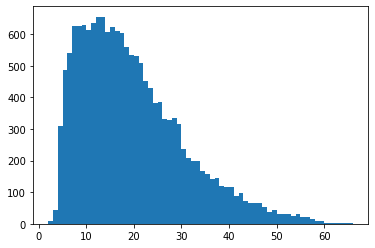

In [13]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [14]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post',  maxlen=maxlen)
  return padded

In [16]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [17]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

# **Task 5: Preparing the Labels**

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [18]:
classes = set(labels)
print(classes)

{'anger', 'fear', 'joy', 'surprise', 'love', 'sadness'}


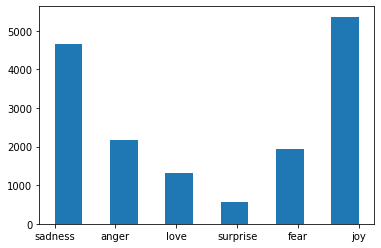

In [19]:
plt.hist(labels, bins=11)
plt.show()

In [20]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items()) 

In [21]:
class_to_index

{'anger': 0, 'fear': 1, 'joy': 2, 'love': 4, 'sadness': 5, 'surprise': 3}

In [22]:
index_to_class

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'surprise', 4: 'love', 5: 'sadness'}

In [23]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [24]:
train_labels = names_to_ids(labels)
print(train_labels[0])

5


# **Task 6: Creating the model**

1. Creating the model
2. Compiling the model

In [25]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen), #input dimension is 10000 and output dimension is 16
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)), #return_sequences means that at every timestep we will have an output. if its false, it wont work
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')                                    

])

model.compile(
    
    loss ='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [26]:
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f34d0bef4d0>>

# **Task 7: Training the Model**

1. Preparing a validation set
2. Training the model

In [33]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [34]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [35]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]

)

Epoch 1/20
500/500 [==============================] - 19s 18ms/step - loss: 1.3242 - accuracy: 0.4788 - val_loss: 0.9497 - val_accuracy: 0.6225
Epoch 2/20
500/500 [==============================] - 8s 15ms/step - loss: 0.6599 - accuracy: 0.7579 - val_loss: 0.6095 - val_accuracy: 0.7970
Epoch 3/20
500/500 [==============================] - 8s 15ms/step - loss: 0.3806 - accuracy: 0.8736 - val_loss: 0.4732 - val_accuracy: 0.8385
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2433 - accuracy: 0.9212 - val_loss: 0.4518 - val_accuracy: 0.8510
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1652 - accuracy: 0.9495 - val_loss: 0.4057 - val_accuracy: 0.8695
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1275 - accuracy: 0.9604 - val_loss: 0.3759 - val_accuracy: 0.8810
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1121 - accuracy: 0.9655 - val_loss: 0.4251 - val_accuracy: 0.878

# **Task 8: Evaluating the Model**

1. Visualizing training history
2. Preparing a test set
3. A look at individual predictions on the test set
4. A look at all preditions on the test set

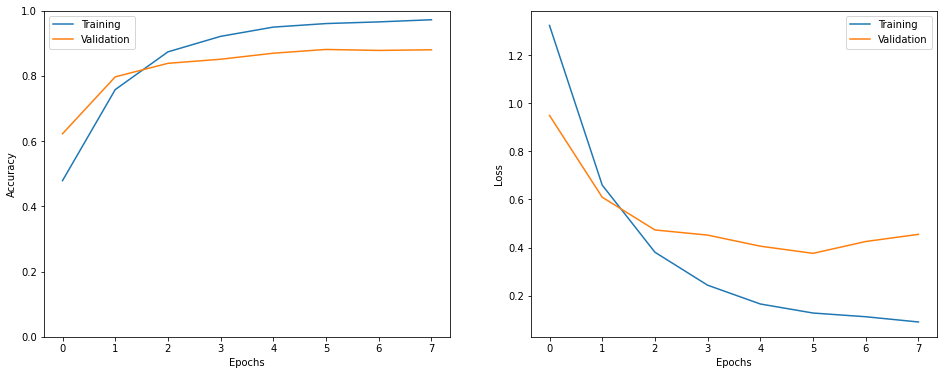

In [40]:
show_history(h)

In [41]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [42]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4385 - accuracy: 0.8735


In [43]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i can never tell him how i feel and it really sucks because i think he gets really bothered by that
Emotion anger
Predicted Emotion: anger


In [44]:
preds = model.predict_classes(test_seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


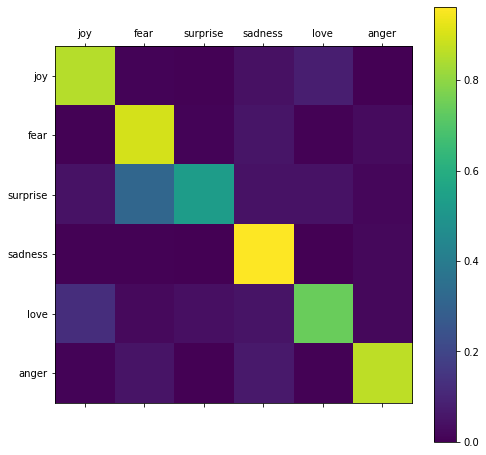

In [45]:
show_confusion_matrix(test_labels, preds, list(classes))